# Assignment 2:

Create a forecast for what the visits would look like for the next year based on the historic data points from the ‘Data for Forecast’ file.

In this assignment, we will be looking for creativity around visual representation of forecast, as well as details on the methodology and the model/s used.

## Load Libraries

In [251]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 12, 7
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
from pandas import DataFrame
import math
import warnings
warnings.filterwarnings('ignore')


In [252]:
data = pd.read_excel('/Users/adamyanayyar/Desktop/Lenovo Assignment/Data for Forecast.xlsx')
data.head()

,Unnamed: 0,Date (week beginning),Selected Period
0,1,"Dec 26, 2011",1284608
1,2,"Jan 2, 2012",13059880
2,3,"Jan 9, 2012",14076974
3,4,"Jan 16, 2012",14337217
4,5,"Jan 23, 2012",14681748


In [253]:
data.drop('Unnamed: 0',axis=1,inplace=True)
data.rename(columns={'Date (week beginning)': 'Date'},inplace=True)
data.head()

,Date,Selected Period
0,"Dec 26, 2011",1284608
1,"Jan 2, 2012",13059880
2,"Jan 9, 2012",14076974
3,"Jan 16, 2012",14337217
4,"Jan 23, 2012",14681748


In [254]:
from dateutil.parser import parse
from datetime import datetime as dt
data['Date']=data['Date'].str.replace(',','')
data['Date'] =  pd.to_datetime(data.Date, format='%b %d %Y')

data.head()

,Date,Selected Period
0,2011-12-26,1284608
1,2012-01-02,13059880
2,2012-01-09,14076974
3,2012-01-16,14337217
4,2012-01-23,14681748


In [255]:
data.index = data.Date
data.drop('Date',axis=1,inplace=True)
data.head()

,Selected Period
Date,
2011-12-26,1284608
2012-01-02,13059880
2012-01-09,14076974
2012-01-16,14337217
2012-01-23,14681748


## Exploratory Data Analysis

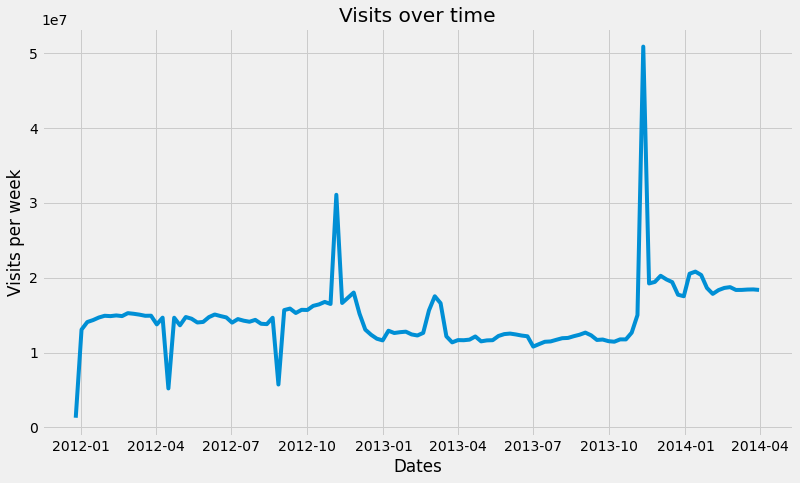

In [303]:
plt.figure(figsize=(12,7))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Visits per week')
plt.plot(data)
plt.title('Visits over time')
plt.show()

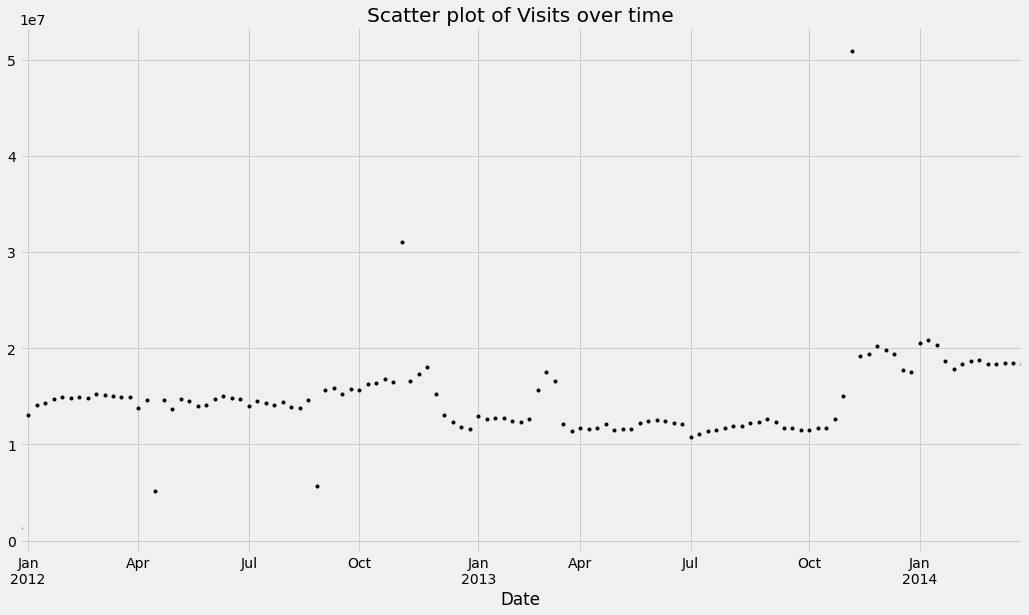

In [257]:
plt.figure(figsize=(16,9))
df_visits = data['Selected Period']
df_visits.plot(style='k.')
plt.title('Scatter plot of Visits over time')
plt.show()

A time series is thought to consist of three systematic components including level, trend, seasonality, and one non-systematic component called noise.

These components are defined as follows:

**Level:** The average value in the series.

**Trend:** The increasing or decreasing value in the series.

**Seasonality:** The repeating short-term cycle in the series.

**Noise:** The random variation in the series.

So let's check if this series is stationary or not because time series analysis only works with stationary data.

### Check Stationarity

<Figure size 864x504 with 0 Axes>

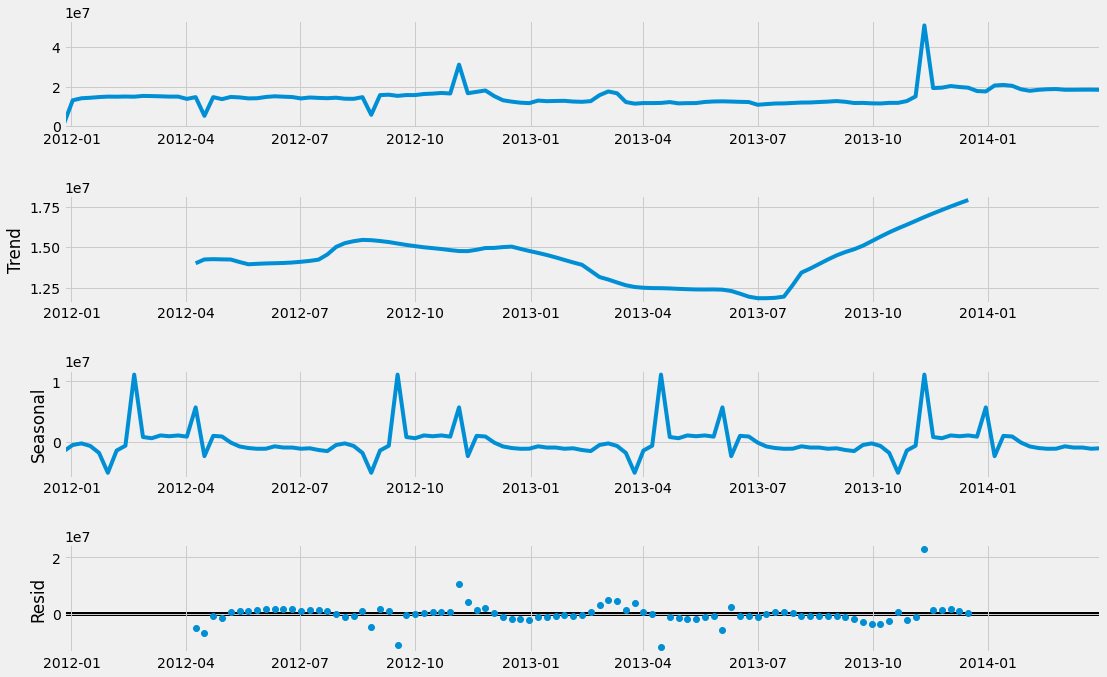

In [305]:
result = seasonal_decompose(data, model='additive', freq = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 10)

The data of visits look stationary with very little seasonality and maybe some trend.
Let's check it with AD Fuller Test.

**ADF (Augmented Dickey-Fuller) Test**

The Dickey-Fuller test is one of the most popular statistical tests. It can be used to determine the presence of unit root in the series, and hence help us understand if the series is stationary or not. The null and alternate hypothesis of this test is:

Null Hypothesis: The series has a unit root (value of a =1)

Alternate Hypothesis: The series has no unit root.

If we fail to reject the null hypothesis, we can say that the series is non-stationary. This means that the series can be linear or difference stationary.

If both mean and standard deviation are flat lines(constant mean and constant variance), the series becomes stationary.

So let's check for stationarity:

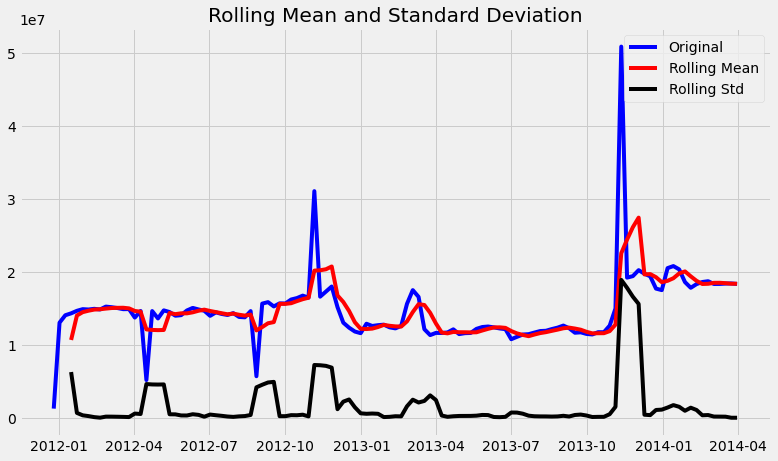

Results of dickey fuller test
Test Statistics                 -3.804315
p-value                          0.002863
No. of lags used                 2.000000
Number of observations used    116.000000
critical value (1%)             -3.488022
critical value (5%)             -2.886797
critical value (10%)            -2.580241
dtype: float64


In [259]:
def test_stationarity(data):
    #Determing rolling statistics
    rolmean = data.rolling(4).mean()     # Rolling mean 4 weeks
    rolstd = data.rolling(4).std()       # Rolling std 4 weeks
    #Plot rolling statistics:
    plt.plot(data, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(data,autolag='AIC')
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(data)

We see that the p-value is smaller than 0.05 so we will reject the Null hypothesis. Also, the test statistics is smaller than the critical values. So the data is Stationary.
However, we can still make it more stationary by taking log of our timeseries or we can take d=1 in our Arima. For now let's take log and check for stationarity again.

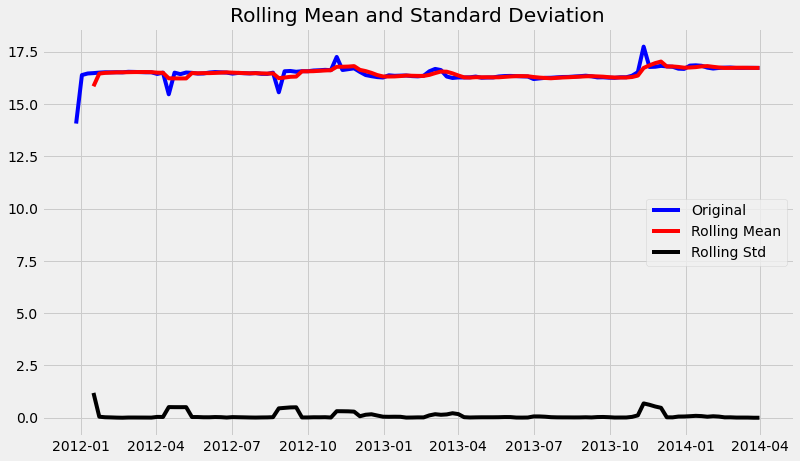

Results of dickey fuller test
Test Statistics                 -5.158253
p-value                          0.000011
No. of lags used                 1.000000
Number of observations used    117.000000
critical value (1%)             -3.487517
critical value (5%)             -2.886578
critical value (10%)            -2.580124
dtype: float64


In [260]:
df_log = np.log(data)
test_stationarity(df_log)


The time series is completely stationary now and ready for modeling.

### Modeling

Now we are going to create an ARIMA model and will train it with the Visits per week. So let us split the data into training and test set and visualize it.

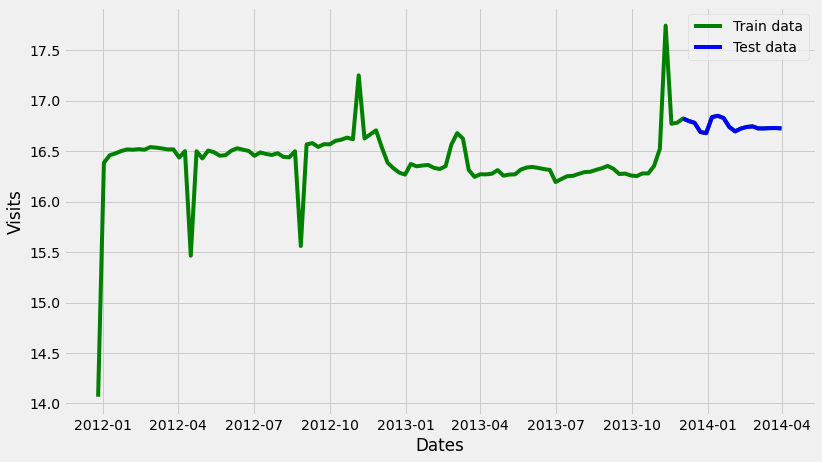

In [261]:
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
#plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Visits')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

For Arima we have to select the lag values for the Autoregression (AR) and Moving Average (MA) parameters, p and q respectively.

We can do this by reviewing Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots.

The code below creates ACF and PACF plots for the series.

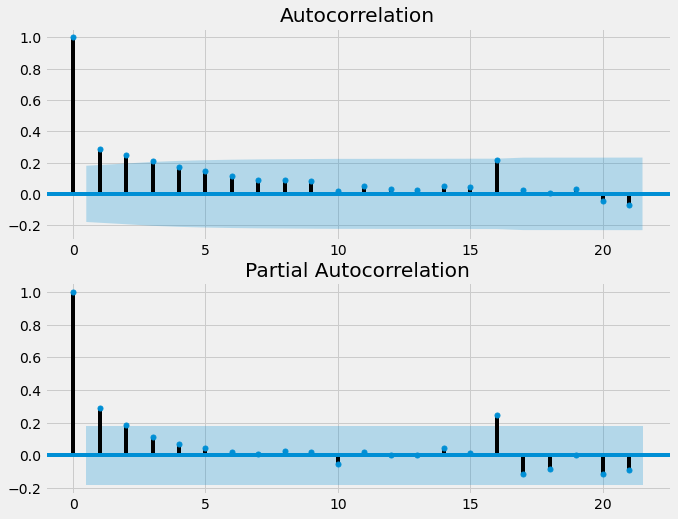

In [306]:
plt.figure(figsize=(10,8))
plt.subplot(211)
plot_acf(df_log, ax=plt.gca())
plt.subplot(212)
plot_pacf(df_log, ax=plt.gca())
plt.show()

Below are some observations from the plots.

- The ACF shows a significant lag for 1st and 2nd week.
- The PACF shows a significant lag for 1st week, with significant lags spotty out to perhaps 16 weeks.
- Both the ACF and PACF show a drop-off at the same point, perhaps suggesting a mix of AR and MA.

A good starting point for the p could be 2 and for q could be 1.

This quick analysis suggests an ARIMA(2,0,1) on the train data may be a good starting point.

In [263]:
test_data['Selected Period'][:5]

Date
2013-12-02    16.823862
2013-12-09    16.799477
2013-12-16    16.781083
2013-12-23    16.690426
2013-12-30    16.678880
Name: Selected Period, dtype: float64

In [264]:
history = [x for x in train_data['Selected Period']]
predictions = list()
for i in range(len(test_data)):
    # predict
    model = ARIMA(history, order=(2,0,1))
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    # observation
    obs = test_data['Selected Period'][i]
    history.append(obs)
    print('Predicted=%.3f, Expected=%.3f' % (yhat, obs))
    
# report performance
rmse = np.sqrt(mean_squared_error(test_data, predictions))
print('RMSE: %.3f' % (rmse))

Predicted=16.632, Expected=16.824
Predicted=16.647, Expected=16.799
Predicted=16.653, Expected=16.781
Predicted=16.651, Expected=16.690
Predicted=16.622, Expected=16.679
Predicted=16.602, Expected=16.837
Predicted=16.647, Expected=16.851
Predicted=16.688, Expected=16.829
Predicted=16.702, Expected=16.740
Predicted=16.678, Expected=16.697
Predicted=16.649, Expected=16.725
Predicted=16.644, Expected=16.740
Predicted=16.651, Expected=16.746
Predicted=16.658, Expected=16.726
Predicted=16.656, Expected=16.726
Predicted=16.655, Expected=16.729
Predicted=16.657, Expected=16.730
Predicted=16.659, Expected=16.726
RMSE: 0.118


This is a good start, but we may be able to get improved results with a better configured ARIMA model.

#### Evaluate combinations of p, d and q values for our ARIMA model

In [265]:
# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    X = X.astype('float32')
    train_size = int(len(X) * 0.9)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    rmse = np.sqrt(mean_squared_error(test, predictions))
    return rmse

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(dataset, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE= %.3f' % (order,rmse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

p_values = [0,1,2,3,4]   
d_values = [0,1,2]          
q_values = [0,1,2,3,4]   
warnings.filterwarnings("ignore")
evaluate_models(df_log['Selected Period'], p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE= 0.306
ARIMA(0, 0, 1) RMSE= 0.234
ARIMA(0, 0, 2) RMSE= 0.197
ARIMA(0, 0, 3) RMSE= 0.179
ARIMA(0, 0, 4) RMSE= 0.165
ARIMA(0, 1, 0) RMSE= 0.045
ARIMA(0, 1, 1) RMSE= 0.057
ARIMA(0, 1, 2) RMSE= 0.056
ARIMA(0, 1, 3) RMSE= 0.053
ARIMA(0, 1, 4) RMSE= 0.051
ARIMA(0, 2, 0) RMSE= 0.053
ARIMA(0, 2, 1) RMSE= 0.039
ARIMA(0, 2, 2) RMSE= 0.044
ARIMA(0, 2, 3) RMSE= 0.044
ARIMA(0, 2, 4) RMSE= 0.042
ARIMA(1, 0, 0) RMSE= 0.169
ARIMA(1, 0, 1) RMSE= 0.118
ARIMA(1, 1, 0) RMSE= 0.056
ARIMA(1, 1, 1) RMSE= 0.054
ARIMA(1, 1, 2) RMSE= 0.044
ARIMA(1, 1, 4) RMSE= 0.049
ARIMA(1, 2, 0) RMSE= 0.057
ARIMA(1, 2, 1) RMSE= 0.051
ARIMA(1, 2, 2) RMSE= 0.044
ARIMA(1, 2, 4) RMSE= 0.046
ARIMA(2, 0, 0) RMSE= 0.135
ARIMA(2, 0, 1) RMSE= 0.122
ARIMA(2, 1, 0) RMSE= 0.060
ARIMA(2, 1, 1) RMSE= 0.056
ARIMA(2, 1, 2) RMSE= 0.055
ARIMA(2, 2, 0) RMSE= 0.070
ARIMA(2, 2, 1) RMSE= 0.053
ARIMA(2, 2, 2) RMSE= 0.041
ARIMA(3, 0, 0) RMSE= 0.125
ARIMA(3, 0, 1) RMSE= 0.123
ARIMA(3, 0, 2) RMSE= 0.177
ARIMA(3, 0, 3) RMSE= 0.171
A

We can also perform Auto Arima to get the best order for ARIMA, in Auto Arima we can select the order with the least AIC .

In [266]:
#Let's select the best order based on the smallest rmse values from above model.
Orders = [(0,1,0),(0,1,1),(0,1,2),(0,1,3),(0,1,4),(0,2,0),(0,2,1),(0,2,2),(1,1,0),
          (1,1,1),(1,1,2),(1,1,4),(1,2,0),(1,2,1),(1,2,2),(1,2,4),(2,1,2),(2,2,1),(2,2,2),
          (3,1,2),(3,2,3),(4,1,1),(4,2,1)]
for x in Orders:
    model = ARIMA(train, order=x)
    fitted = model.fit()
    print('ARIMA%s, AIC=%.3f' % (x,fitted.aic))

ARIMA(0, 1, 0), AIC=83.198
ARIMA(0, 1, 1), AIC=68.838
ARIMA(0, 1, 2), AIC=70.802
ARIMA(0, 1, 3), AIC=72.125
ARIMA(0, 1, 4), AIC=73.184
ARIMA(0, 2, 0), AIC=157.398
ARIMA(0, 2, 1), AIC=89.094
ARIMA(0, 2, 2), AIC=77.066
ARIMA(1, 1, 0), AIC=73.126
ARIMA(1, 1, 1), AIC=70.785
ARIMA(1, 1, 2), AIC=70.530
ARIMA(1, 1, 4), AIC=74.381
ARIMA(1, 2, 0), AIC=113.261
ARIMA(1, 2, 1), AIC=79.858
ARIMA(1, 2, 2), AIC=79.054
ARIMA(1, 2, 4), AIC=81.760
ARIMA(2, 1, 2), AIC=72.403
ARIMA(2, 2, 1), AIC=79.633
ARIMA(2, 2, 2), AIC=80.941
ARIMA(3, 1, 2), AIC=74.386
ARIMA(3, 2, 3), AIC=84.825
ARIMA(4, 1, 1), AIC=74.386
ARIMA(4, 2, 1), AIC=83.137


For our case let's go ahead with order (1,1,2) which has less error and check the residuals.

### Review Residual Errors
A good final check of a model is to review residual forecast errors.

Ideally, the distribution of residual errors should be a Gaussian with a zero mean.

We can check this by plotting the residuals with a histogram and density plots.

**ARIMA(1,1,2)**

                             ARIMA Model Results                              
Dep. Variable:      D.Selected Period   No. Observations:                  100
Model:                 ARIMA(1, 1, 2)   Log Likelihood                 -30.265
Method:                       css-mle   S.D. of innovations              0.323
Date:                Wed, 05 May 2021   AIC                             70.530
Time:                        13:59:24   BIC                             83.556
Sample:                    01-02-2012   HQIC                            75.802
                         - 11-25-2013                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       0.0035      0.004      0.851      0.395      -0.005       0.011
ar.L1.D.Selected Period     0.8068      0.202      3.987      0.000       0.410       1.203


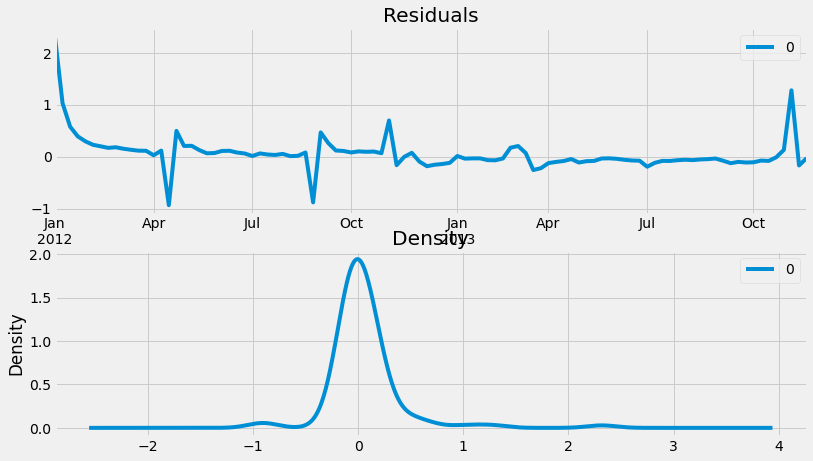

In [275]:
model = ARIMA(train, order=(1,1,2))
fitted = model.fit(disp=0)
print(fitted.summary())

residuals = pd.DataFrame(fitted.resid)
fig, ax = plt.subplots(2,1)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

The residual errors seem fine with near zero mean and uniform variance. Let’s plot the actuals against the fitted values using plot_predict().


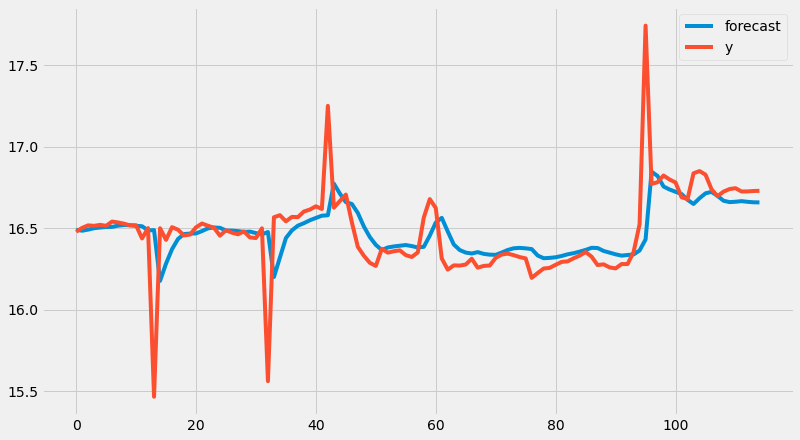

In [276]:
# Actual vs Fitted
model_fit.plot_predict(dynamic=False)
plt.show()

Let's now forecast the Test data.

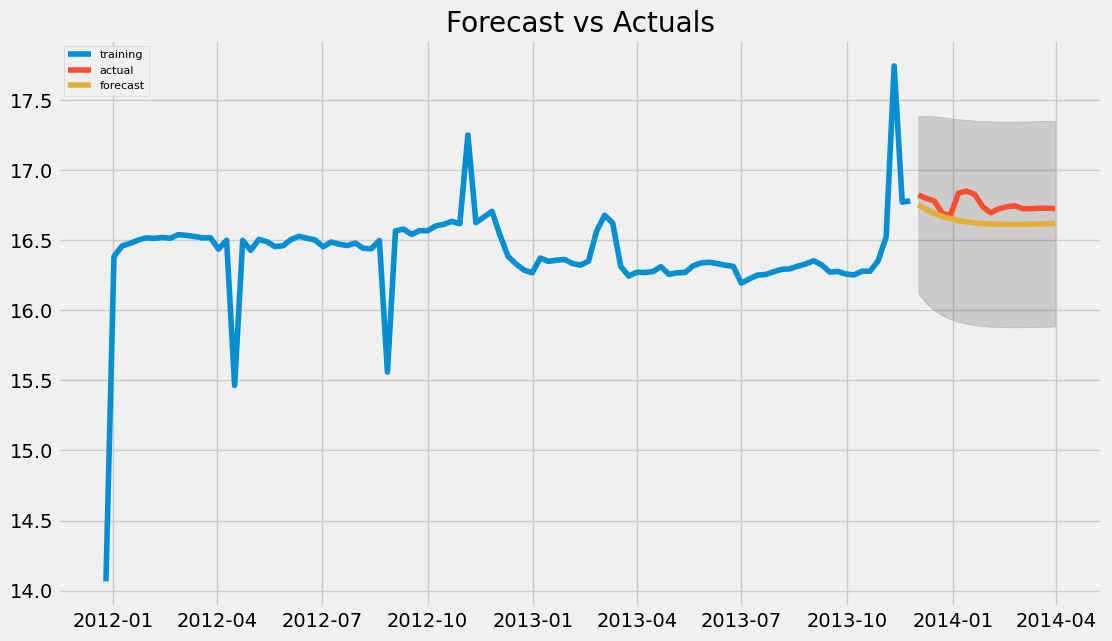

In [277]:
# Forecast
fc, se, conf = fitted.forecast(18, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,7), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

From the chart, the ARIMA(1,1,2) model seems to give a directionally correct forecast. And the actual observed values lie within the 95% confidence band. That seems fine.

But each of the predicted forecasts is consistently below the actuals. That means, by adding a small constant to our forecast, the accuracy will certainly improve. So, there is definitely scope for improvement.

So, what I am going to do is to increase the order of differencing to two and check the forecast again.

**ARIMA(1,2,2)**

AIC: 79.05365296873453


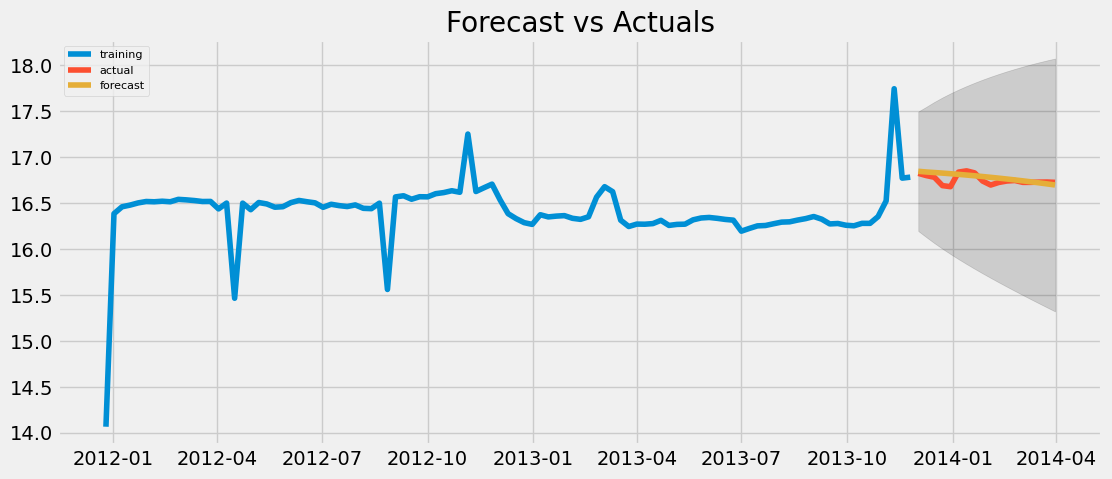

In [280]:
model = ARIMA(train, order=(1, 2, 2))  
fitted = model.fit(disp=-1)  
print('AIC:', fitted.aic)

# Forecast
fc, se, conf = fitted.forecast(18, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

The forecast is doing great on our test value but the aic value has increased, but anyway let's stick with (1,2,2) for future forecast.

Also in this forecast the value is declining over time but in original data the value is not declining, so we will stick with ARIMA(1,2,2)

In [170]:
#fc_series_original = np.exp(fc_series)
#fc_series_original
check = test.copy()
check['Selected Period'] = np.exp(check['Selected Period'])
check['Predicted'] = np.exp(fc_series)

In [176]:
check.sample(5)

,Selected Period,Predicted
Date,,
2014-03-24,18432161.0,1.806057e+07
2014-01-13,20812220.0,1.988399e+07
2014-02-10,18342182.0,1.922383e+07
2014-03-03,18360715.0,1.866606e+07
2014-01-20,20359660.0,1.972847e+07


### Final Forecast by ARIMA

Now we will apply Arima(1,2,2) on the entire data and do forecast for the next year (52 Weeks)

AIC: 62.162276906365946


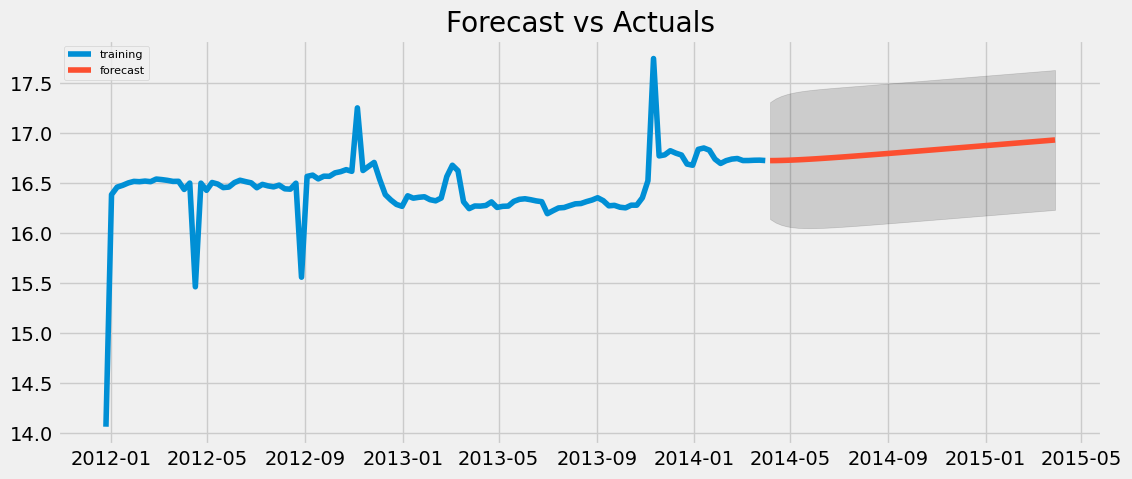

In [282]:
model = ARIMA(df_log, order=(1, 1, 2))  
fitted = model.fit(disp=-1)  
print('AIC:', fitted.aic)

# Forecast
fc, se, conf = fitted.forecast(52, alpha=0.05)  # 95% conf
index_of_fc = pd.date_range(data.index[-1], periods = 52, freq='W')

# Make as pandas series
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(conf[:, 0], index=index_of_fc)
upper_series = pd.Series(conf[:, 1], index=index_of_fc)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(df_log, label='training')
#plt.plot(test, label='actual')

plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

Although the forecast is good but ARIMA models doesn't capture any seasonality so we will now try SARIMAX model for better forecast.

### SARIMAX MODEL

In the pacf and acf plots we saw significant lags at 16, so we can set seasonality as 16 (weeks) and check if we can get a better prediction.

In [291]:
# We can check for both Seasonality at m=16 and  m=52(year)
import pmdarima as pm

# Seasonal - fit stepwise auto-ARIMA
smodel = pm.auto_arima(train_data, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=16,
                         start_P=0,D=1, seasonal=True,
                         d=None, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[16]             : AIC=32.282, Time=1.61 sec
 ARIMA(0,1,0)(0,1,0)[16]             : AIC=67.608, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[16]             : AIC=42.931, Time=0.43 sec
 ARIMA(0,1,1)(0,1,1)[16]             : AIC=30.369, Time=0.67 sec
 ARIMA(0,1,1)(0,1,0)[16]             : AIC=37.203, Time=0.37 sec
 ARIMA(0,1,1)(1,1,1)[16]             : AIC=inf, Time=3.85 sec
 ARIMA(0,1,1)(0,1,2)[16]             : AIC=inf, Time=4.05 sec
 ARIMA(0,1,1)(1,1,0)[16]             : AIC=34.699, Time=0.54 sec
 ARIMA(0,1,1)(1,1,2)[16]             : AIC=inf, Time=8.61 sec
 ARIMA(0,1,0)(0,1,1)[16]             : AIC=53.087, Time=0.57 sec
 ARIMA(0,1,2)(0,1,1)[16]             : AIC=32.321, Time=1.66 sec
 ARIMA(1,1,0)(0,1,1)[16]             : AIC=inf, Time=1.20 sec
 ARIMA(1,1,2)(0,1,1)[16]             : AIC=34.266, Time=1.72 sec
 ARIMA(0,1,1)(0,1,1)[16] intercept   : AIC=31.220, Time=1.57 sec

Best model:  ARIMA(0,1,1)(0,1,1)[16]          
Total fit t

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   98
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 16)   Log Likelihood                 -12.185
Date:                            Wed, 05 May 2021   AIC                             30.369
Time:                                    14:14:06   BIC                             37.553
Sample:                                         0   HQIC                            33.251
                                             - 98                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6142      0.108     -5.686      0.000      -0.826      -0.403
ma.S.L16      -0.7183      0.206     -3.494      0.000      -1.121      -0.315
sigma2         0.0684      0.009      7.970      0.000       0.052       0.085
===================================================================================
Ljung-Box (Q):                       15.02   Jarque-Bera (JB):               380.74
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.02   Skew:                             1.63
Prob(H) (two-sided):                  0.97   Kurtosis:                        13.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

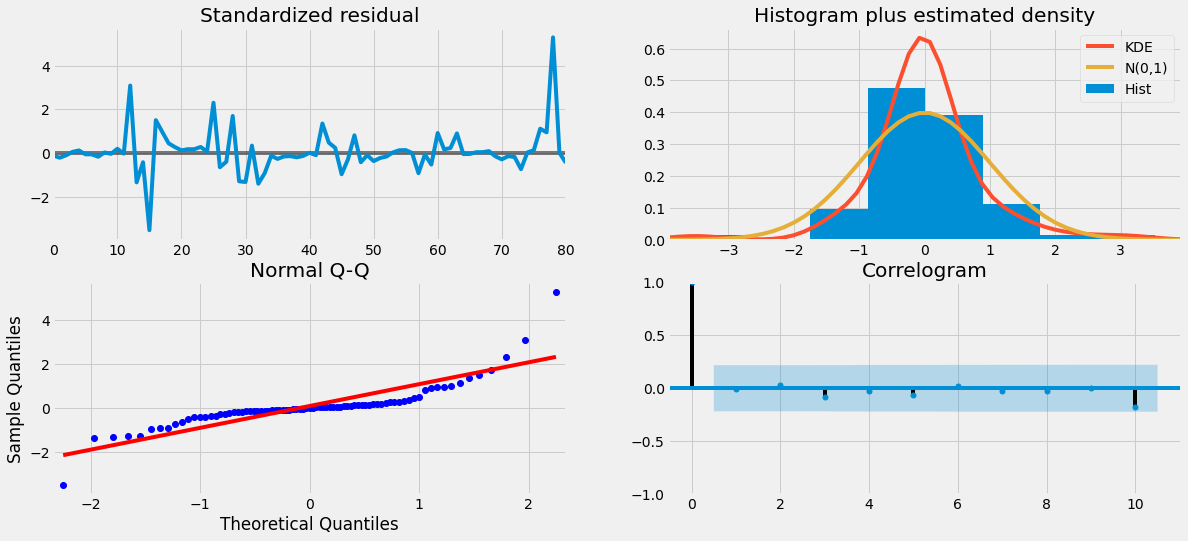

In [292]:
smodel.plot_diagnostics(figsize=(18, 8))
plt.show()

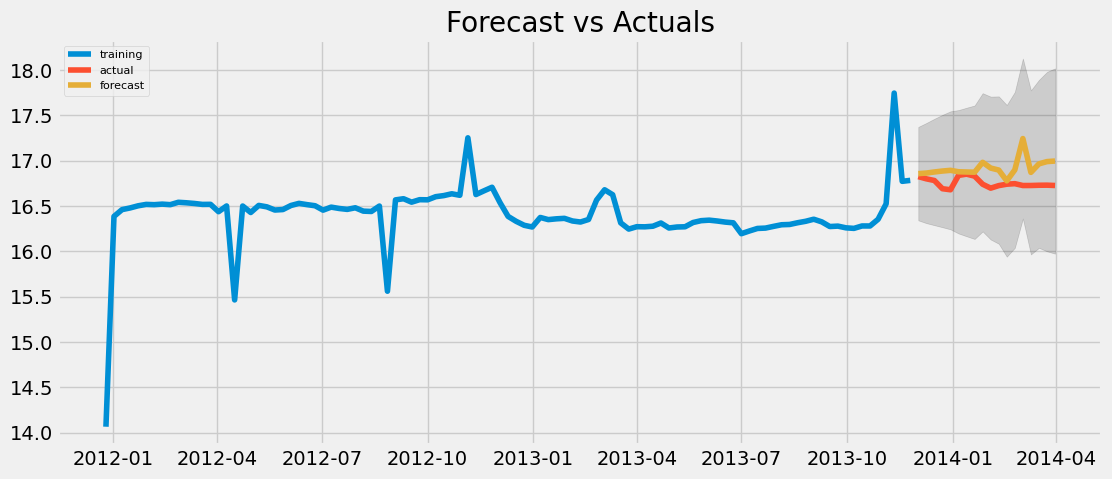

In [293]:
# Forecast
fc, conf = smodel.predict(18, return_conf_int=True)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [286]:
print('RMSE Score:', np.sqrt(mean_squared_error(test,fc_series)))

RMSE Score: 0.2039382711987934


As we can see our error has increased significantly than the ARIMA.
So now it depends on how we want our predictions, if we want the error to be as small as possible, then we can go ahead with ARIMA, if we want to check the highs and lows in our data, then we can stick with SARIMAX.

**If we had more data, we could have predicted the seasonality more accurately as there is some seasonality after 4 months in 2012-2013, and a significant 1 year seasonality in 2012-11 and 2013-11.**

For our Final model we will go ahead with 1 year seasonality due to the sharp spike in November but this is contradictory.

## SARIMAX Forecast for 1 year

In [298]:
smodel = pm.auto_arima(data, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=52,
                         start_P=0,D=1, seasonal=True,
                         d=None, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)
smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[52]             : AIC=inf, Time=2.40 sec
 ARIMA(0,1,0)(0,1,0)[52]             : AIC=2303.053, Time=0.13 sec
 ARIMA(1,1,0)(1,1,0)[52]             : AIC=inf, Time=4.66 sec
 ARIMA(0,1,1)(0,1,1)[52]             : AIC=inf, Time=2.04 sec
 ARIMA(0,1,0)(1,1,0)[52]             : AIC=inf, Time=2.51 sec
 ARIMA(0,1,0)(0,1,1)[52]             : AIC=inf, Time=2.41 sec
 ARIMA(0,1,0)(1,1,1)[52]             : AIC=2264.698, Time=4.41 sec
 ARIMA(0,1,0)(2,1,1)[52]             : AIC=inf, Time=9.74 sec
 ARIMA(0,1,0)(1,1,2)[52]             : AIC=2266.298, Time=15.54 sec
 ARIMA(0,1,0)(0,1,2)[52]             : AIC=inf, Time=5.35 sec
 ARIMA(0,1,0)(2,1,0)[52]             : AIC=inf, Time=13.16 sec
 ARIMA(0,1,0)(2,1,2)[52]             : AIC=inf, Time=22.73 sec
 ARIMA(1,1,0)(1,1,1)[52]             : AIC=2249.763, Time=9.73 sec
 ARIMA(1,1,0)(0,1,1)[52]             : AIC=inf, Time=1.55 sec
 ARIMA(1,1,0)(2,1,1)[52]             : AIC=inf, Time=14.88 sec
 AR

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  119
Model:             SARIMAX(0, 1, 1)x(1, 1, [], 52)   Log Likelihood               -1117.046
Date:                             Wed, 05 May 2021   AIC                           2240.092
Time:                                     15:35:33   BIC                           2246.661
Sample:                                          0   HQIC                          2242.688
                                             - 119                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6204      0.107     -5.824      0.000      -0.829      -0.412
ar.S.L52      -0.8294      0.129     -6.421      0.000      -1.083      -0.576
sigma2       3.63e+13   6.26e-15   5.79e+27      0.000    3.63e+13    3.63e+13
===================================================================================
Ljung-Box (Q):                        8.79   Jarque-Bera (JB):              4846.88
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):              26.75   Skew:                             5.66
Prob(H) (two-sided):                  0.00   Kurtosis:                        43.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.38e+42. Standard errors may be unstable.
"""

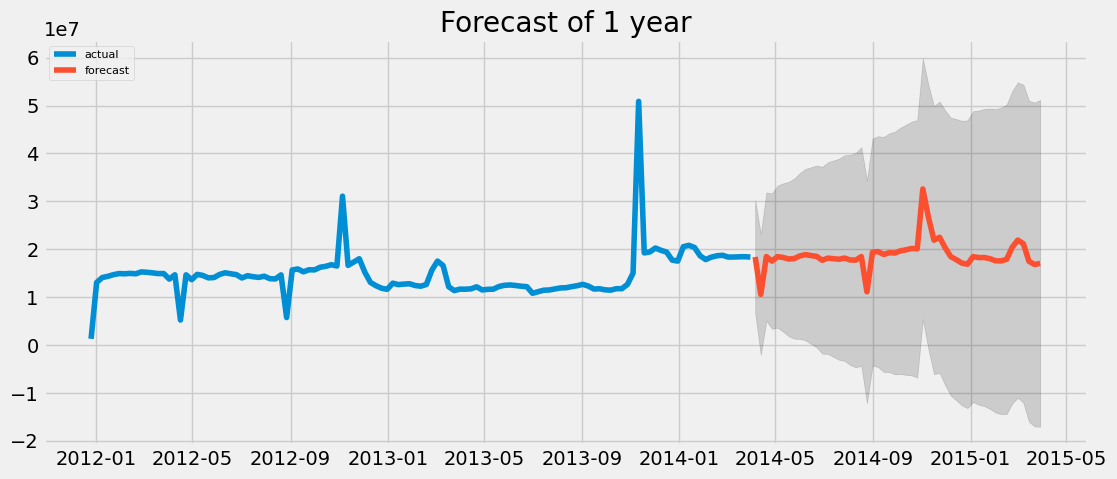

In [301]:
# Forecast
fc, conf = smodel.predict(52, return_conf_int=True)  # 95% conf
index_of_fc = pd.date_range(data.index[-1], periods = 52, freq='W')

# Make as pandas series
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(conf[:, 0], index=index_of_fc)
upper_series = pd.Series(conf[:, 1], index=index_of_fc)

# Plot
plt.figure(figsize=(12,5), dpi=100)
#plt.plot(train, label='training')
plt.plot(data, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast of 1 year')
plt.legend(loc='upper left', fontsize=8)
plt.show()

**So above are the forecasts with 95% confidence interval, for next year. Here we have selected the seasonality as 52 weeks (1 year). Based on more data we can make better decisions about seasonality. For predicted values if we want minimum error then we can select ARIMA as our final model, if we want to add seasonality then we can select SARIMAX model.**